In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from nuflux.detgeo import SimulateDecays, SimulateDetector, check_mem, plot, phi_distribution

In [138]:
cc = SimulateDecays('mutristan l', N_evals = 1e5)

Simulation: mutristan (l) parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.65 s


In [139]:
Lss = 30
geom = "det_v2"
collision = 'mu+mu+'
sims = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)
Lss = 540
sims2 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: muTRISTAN (L) (μ+μ+) at L = 30.00 m with Det v2 as a detector
Total Count: 3.84e+11 events; took 0.839 s
Simulation: muTRISTAN (L) (μ+μ+) at L = 540.00 m with Det v2 as a detector
Total Count: 2.02e+11 events; took 0.695 s


In [141]:
cc = SimulateDecays('mucol s2', N_evals = 1e5)

Simulation: mucol s2 parameter set with 1.000e+05 evaluations 
1.875e+05 MC generations; took 3.71 s


In [142]:
Lss = 75
collision = 'mu+mu-'
sims3 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)
Lss = 400
collision = 'mu+mu-'
sims4 = SimulateDetector(cc, geom, particle = None, Lss = Lss).run(show_components = 0, show_time = 0, collision = collision)

Simulation: MuCoL (s2) (μ+μ-) at L = 75.00 m with Det v2 as a detector
Total Count: 1.59e+11 events; took 1.57 s
Simulation: MuCoL (s2) (μ+μ-) at L = 400.00 m with Det v2 as a detector
Total Count: 5.07e+11 events; took 1.46 s


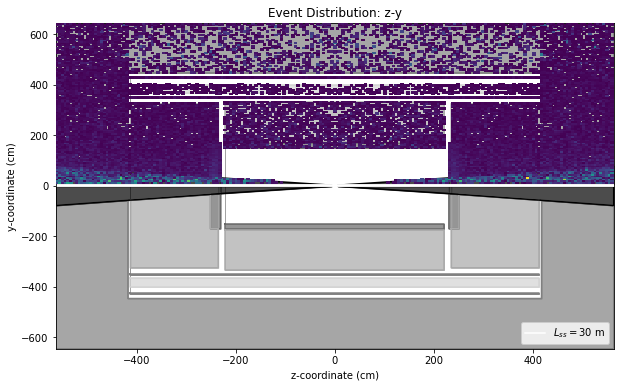

In [143]:
plot(sims, fs = (10,6), orientation = 'z-y')

In [39]:
#phi_distribution(sims, nbins = 50)

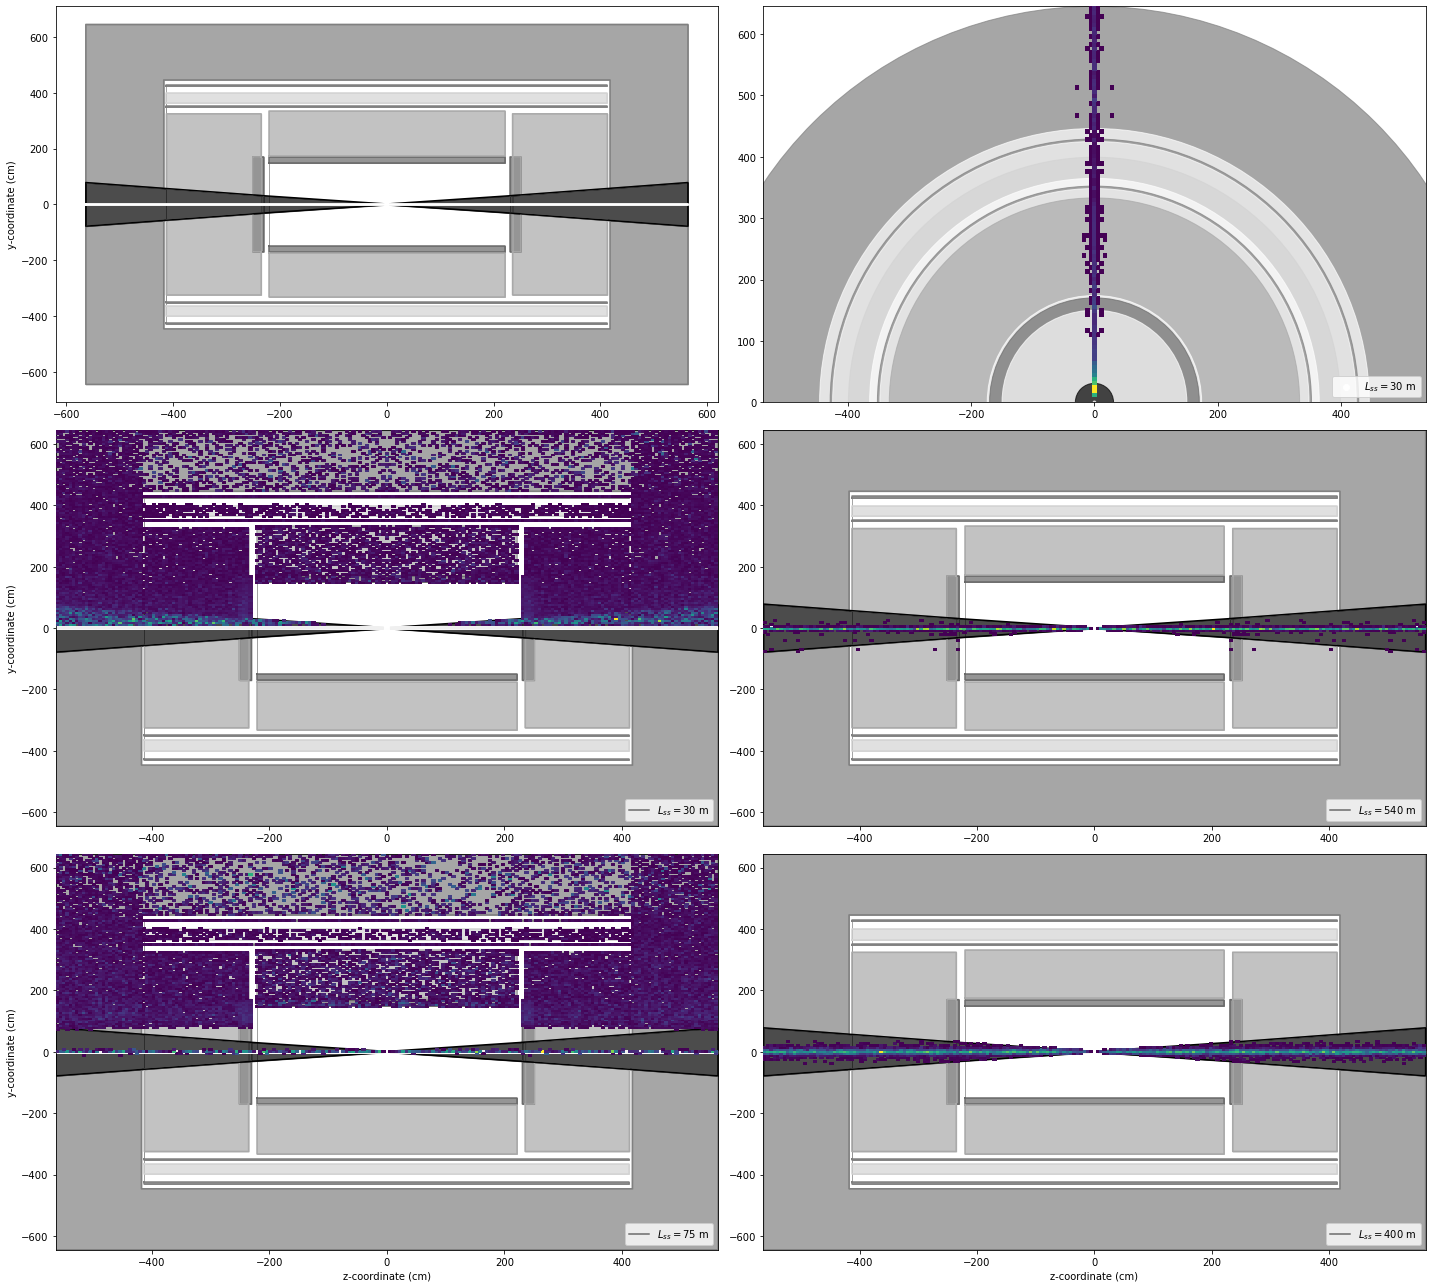

In [157]:
from nuflux.detgeo import plot_det, plot
fig, axs = plt.subplots(3,2, figsize = (20,18))
plot_det('det_v2', axs[0,0], xl  = False)
plot(sims, orientation = 'x-y', ax = axs[0,1], title = False, xl = False, yl = False)
plot(sims, ax = axs[1,0], title = False, xl = False)
plot(sims2, ax = axs[1,1], title = False, xl = False, yl = False)
plot(sims3, ax = axs[2,0], title = False)
plot(sims4, ax = axs[2,1], title = False, yl = False)

plt.tight_layout()
plt.show()